<a href="https://colab.research.google.com/github/jakub7535/Correlation_covariance_tutorial/blob/main/correlation_covariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
import ipywidgets as ipw
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
""" Jupyter is widened to full width of the screen. """
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
""" Class to calculate graph parameters and draw items on an ax of figure. """

class Graph:
    def __init__(self, data, ax, size_param=10):
        self.size_param = size_param
        self.data = data
        self.ax = ax
        self.square_size = None
        self.ax.locator_params(nbins=int(10))
        self.ax.tick_params(labelsize=size_param)

    """ the graph is always a square of a side
     equal to a bigger St.d(X or Y) * 5 """

    def set_square_size(self):
        self.square_size = 5 * max(self.data.x_std, self.data.y_std)

    def automatically_set_axis_limit(self):
        self.ax.set_xlim(self.data.x_mu - 0.5 * self.square_size,
                         self.data.x_mu + 0.5 * self.square_size)
        self.ax.set_ylim(self.data.y_mu - 0.5 * self.square_size,
                         self.data.y_mu + 0.5 * self.square_size)

    def manually_set_axis_limit(self, x_lim, y_lim):
        self.ax.set_xlim(x_lim)
        self.ax.set_ylim(y_lim)

    """ drawing a trend(red) line y = 'a_trend_line' * x + 'b_trend_line',
    on which the trend was planned """

    def draw_trend_line(self):
        a_trend_line = math.tan(self.data.alpha_rad)
        b_trend_line = self.data.y_mu - a_trend_line * self.data.x_mu
        x_lim = self.ax.get_xlim()
        x_trend_line = np.array(x_lim)
        y_trend_line = a_trend_line * x_trend_line + b_trend_line
        self.ax.plot(x_trend_line, y_trend_line, '-r')
        
        
    """ drawing a linear regression line y = 'a_lr_line' * x + 'b_lr_line',
    on which the trend was planned """
    
    def draw_linear_regression_line(self):
        a_lr_line =  linregress(self.data.X_data, self.data.Y_data).slope
        b_lr_line =  linregress(self.data.X_data, self.data.Y_data).intercept
        x_lim = self.ax.get_xlim()
        x_lr_line = np.array(x_lim)
        y_lr_line = a_lr_line * x_lr_line + b_lr_line
        self.ax.plot(x_lr_line, y_lr_line, '-y')
        
    """ drawing center of mass of the data"""

    def drawing_center_of_new_coordinate_system(self):
        self.ax.scatter(self.data.x_mu, self.data.y_mu,
                        s=self.size_param * 25, color='y')

    def draw_x_y_axis_new_coordinate_system(self):
        x_lim = self.ax.get_xlim()
        y_lim = self.ax.get_ylim()
        self.ax.plot(x_lim, [self.data.y_mu, self.data.y_mu], '--c', )
        self.ax.plot([self.data.x_mu, self.data.x_mu], y_lim, '--c')

    def draw_grid(self):
        self.ax.grid(color='b', ls='-.', lw=0.25)

    """ plotting multiple color points """

    def plotting_colored_points(self):
        for point_x, point_y in zip(self.data.X_data, self.data.Y_data):
            if (point_x - self.data.x_mu) * (point_y - self.data.y_mu) > 0:
                self.ax.scatter(point_x, point_y, s=self.size_param, color='g')
            elif (point_x - self.data.x_mu) * (point_y - self.data.y_mu) < 0:
                self.ax.scatter(point_x, point_y, s=self.size_param, color='r')
            else:
                self.ax.scatter(point_x, point_y, s=self.size_param, color='b')

    """ plotting one color points(black) """

    def plotting_black_points(self):
        self.ax.scatter(self.data.X_data, self.data.Y_data,
                        s=self.size_param, color='k')

    def drawing_cov_rectangles(self):
        """ calculating covariance with perfect linearity of points
        with the same std of X and Y """
        covariance_ideal = self.data.x_std * self.data.y_std
        """ calculating sides of rectangles for covariance 
        and ideal covariance """

        a_cov = (abs(self.data.cov / self.data.slope_line)) ** 0.5
        a_cov_ideal = (abs(covariance_ideal / self.data.slope_line)) ** 0.5
        color_rect = 'g'

        """ when the covariance is negative rectangles are being drawn
         in second quarter """

        if self.data.cov < 0:
            a_cov = -a_cov
            a_cov_ideal = -a_cov_ideal
            color_rect = 'r'

        b_cov = self.data.cov / a_cov
        b_cov_ideal = abs(covariance_ideal / a_cov_ideal)

        """drawing rectangles"""
        plt.gca().add_patch(plt.Rectangle((self.data.x_mu, self.data.y_mu),
                        a_cov, b_cov, fill=False, color=color_rect,
                        linewidth=self.size_param / 8))
        plt.gca().add_patch(plt.Rectangle((self.data.x_mu, self.data.y_mu),
                        a_cov_ideal, b_cov_ideal, fill=False, color='b',
                        linewidth=self.size_param / 8))

    def draw_all(self):
        self.set_square_size()
        self.automatically_set_axis_limit()
        self.plotting_colored_points()
        self.draw_trend_line()
        self.draw_x_y_axis_new_coordinate_system()
        self.drawing_center_of_new_coordinate_system()
        self.draw_grid()
        #self.draw_text()
        #self.drawing_cov_rectangles()

In [ ]:
""" Class to draw text on the graph. After creating text, 
coordinate for next potential text is calculated. """

class TextOnGraph:
    def __init__(self, graph):
        self.graph = graph
        self.ax = graph.ax
        self.x_text = self.ax.get_xlim()[0] + 0.02 * self.graph.square_size
        self.y_text = self.ax.get_ylim()[1] - 0.02 * self.graph.square_size
        self.label_param = {'color': 'green', 
                            'fontsize': self.graph.size_param * 1.6,'ha': 'left',
                            'va': 'top', 'bbox': dict(boxstyle="round",
                            fc="white", ec="black", pad=0.2)}
        
    def draw_text(self, text, color = 'g'):
        label_param = self.label_param
        label_param['color'] = color
        self.ax.text(self.x_text, self.y_text, text, label_param)
        self.y_text -= 0.05 * self.graph.square_size

In [ ]:
""" Class to create data and calculate useful parameters of it. """

class Data:
    def __init__(self, alpha, y_sigma, sample_number=50, x_mu=180, x_sigma=5,
                 y_mu=80):
        self.alpha = alpha
        self.alpha_rad = math.radians(alpha)
        self.slope_line = math.tan(self.alpha_rad)
        self.y_sigma = y_sigma
        self.sample_number = sample_number
        self.x_sigma = x_sigma
        self.y_sigma = y_sigma * x_sigma
        self.x_mu = x_mu
        self.y_mu = y_mu
        self.x_std = None
        self.y_std = None
        self.X_data = None
        self.Y_data = None
        self.cor = None
        self.cov = None


    def create_data(self):
        """ We are getting two numpy samples in normal distribution.
        The numbers are randomly chosen from normal dist of mean=0 and
        standard deviation=x_sigma and y_sigma. """
        self.X_data = np.random.normal(0, self.x_sigma, self.sample_number)
        self.Y_data = np.random.normal(0, self.y_sigma, self.sample_number)

        """ Numpy sample can have different mean and St.d 
        that planned (e.g. -0.87 instead of 0). 
        That is the reason to adjust them again to mean=0 and std=x_or_y_std """
        self.X_data = self.X_data - np.mean(self.X_data)
        self.Y_data = self.Y_data - np.mean(self.Y_data)
        if self.X_data.std() != 0 and self.Y_data.std() != 0:
          self.X_data = (self.X_data / self.X_data.std()) * self.x_sigma
          self.Y_data = (self.Y_data / self.Y_data.std()) * self.y_sigma
        """ The next step is to rotate data by alpha angle around point(0,0).
        Now distribution looks like tilted ellipse. """
        transformation_matrix = np.array(
                [[math.cos(self.alpha_rad), math.sin(self.alpha_rad)],
                [-math.sin(self.alpha_rad), math.cos(self.alpha_rad)]])
        data_matrix = np.array([self.X_data, self.Y_data])
        new_parameters = data_matrix.transpose().dot(transformation_matrix)
        new_parameters = new_parameters.transpose()

        """  Data is being  shifted to new center of mass. 
        Planned x_mu and y_mu. """
        self.X_data = new_parameters[0] + self.x_mu
        self.Y_data = new_parameters[1] + self.y_mu
        """ Calculating useful parameters of the instance of a class """
        self.x_std = np.std(self.X_data)
        self.y_std = np.std(self.Y_data)
        self.cov = np.cov(self.X_data, self.Y_data, bias=True)[0][1]
        self.cor = np.corrcoef(self.X_data, self.Y_data)[0][-1]

In [ ]:
""" Class to create standardized version of data and its paramters. """


class DataStandardized:
    def __init__(self, old_data):
        self.X_data = (old_data.X_data - old_data.x_mu) / old_data.x_std
        self.Y_data = (old_data.Y_data - old_data.y_mu) / old_data.y_std
        self.alpha = 45 if old_data.alpha >= 0 else -45
        self.alpha_rad = math.radians(self.alpha)
        self.slope_line = math.tan(self.alpha_rad)
        self.sample_number = old_data.sample_number
        self.x_mu = 0
        self.y_mu = 0
        self.x_std = 1
        self.y_std = 1
        self.cov = np.cov(self.X_data, self.Y_data, bias=True)[0][1]
        self.cor = np.corrcoef(self.X_data, self.Y_data)[0][-1]

In [ ]:
""" program will create the same 'random' 
numbers when parameters are the same """
def same_random_data():
    np.random.seed(0)

In [ ]:
""" Create an interactive graph of data. """

class InteractiveGraph:
    def __init__(self):
        self.data = None
        self.size_param = 8
        self.fig = None
        self.previous_state = None
        
    def create_figure(self, tilt_angle, spread, n_sample_s, grid_box, 
                    trend_line_box, l_reg_box, color_box, rectangles_box, 
                    correlation_box, covariance_box, std_box, standardize_box,
                    axis_box):
        actual_state = (str(grid_box) + str(trend_line_box) + str(l_reg_box) 
            + str(color_box) + str(rectangles_box) + str(correlation_box)
            + str(covariance_box) + str(std_box) + str(standardize_box)
            + str(axis_box))

        if actual_state == self.previous_state or self.previous_state == None:
            self.data = Data(tilt_angle, spread, n_sample_s)
            self.data.create_data()
        self.previous_state = actual_state

        if standardize_box:
            self.fig = plt.figure(figsize=(2*self.size_param, self.size_param))

            ax = self.fig.add_subplot(121)
            ax.set_title('Data', fontsize=self.size_param*2)
            self.create_graph(ax, self.data)

            data_std = DataStandardized(self.data)
            ax_std = self.fig.add_subplot(122)
            ax_std.set_title('Standardized Data', 
                                   fontsize=self.size_param*2)
            self.create_graph(ax_std, data_std)
        else:
            self.fig = plt.figure(figsize=(self.size_param, self.size_param))
            ax = self.fig.add_subplot(111)
            ax.set_title('Soccer players height and weight', fontsize=self.size_param*2)
            ax.set_xlabel('Height', fontsize=self.size_param*2)
            ax.set_ylabel('Weight', fontsize=self.size_param*2)
            self.create_graph(ax, self.data)
        
    def create_graph(self, ax, data):
        #np.random.seed(0)
        data_graph = Graph(data, ax, self.size_param)
        data_graph.set_square_size()
        #data_graph.manually_set_axis_limit((160,200), (78,82))
        data_graph.automatically_set_axis_limit()
        data_graph.plotting_black_points()

        text = TextOnGraph(data_graph)

        if grid_box.value:
            data_graph.draw_grid()
        if axis_box.value:
            data_graph.draw_x_y_axis_new_coordinate_system()
            data_graph.drawing_center_of_new_coordinate_system()
        if trend_line_box.value:
            data_graph.draw_trend_line() 
        if l_reg_box.value:
            data_graph.draw_linear_regression_line()
        if color_box.value:
            data_graph.plotting_colored_points()
        if rectangles_box.value:
            data_graph.drawing_cov_rectangles()    
        if correlation_box.value:
            text.draw_text('Correlation: ' + str(round(data.cor, 4)), 'g')        
        if covariance_box.value:
            text.draw_text('Cavariance: ' + str(round(data.cov, 4)), 'g')
        if std_box.value:
            text.draw_text('Std.X_data: ' + str(round(data.x_std, 4)), 'g')
            text.draw_text('Std:Y_data: ' + str(round(data.y_std, 4)), 'g')
        self.fig.show()

In [ ]:
""" check boxes and their parameters """
style = {'description_width': 'initial'}
box_layout = ipw.Layout(width='60%')
axis_box = ipw.Checkbox(description='Axis', style=style)
grid_box = ipw.Checkbox(description='Grid', style=style)
trend_line_box = ipw.Checkbox(description='Trend line(red)', style=style)
l_reg_box = ipw.Checkbox(description='Lin Reg(yellow)', style=style)
color_box = ipw.Checkbox(description='Color Dots', style=style)
rectangles_box = ipw.Checkbox(description='Cov Rectangles', style=style)
correlation_box = ipw.Checkbox(description='Correlation', style=style)
covariance_box = ipw.Checkbox(description='Covariance', style=style)
std_box = ipw.Checkbox(description='St. Deviation', style=style)
standardize_box = ipw.Checkbox(description='Standardize', style=style)

upper_boxes = ipw.widgets.HBox([grid_box, axis_box, trend_line_box, l_reg_box, 
                                color_box])
lower_boxes = ipw.widgets.HBox([rectangles_box, correlation_box, 
                                covariance_box, std_box, standardize_box])
all_boxes = ipw.widgets.VBox([upper_boxes, lower_boxes], 
                               layout = box_layout)

""" sliders and their parameters """
slider_layout = ipw.Layout(width='400px', height='20px')

n_sample_s = ipw.widgets.IntSlider(description='dots number', 
                        value=50, min=5, max = 200, step=5, 
                        layout = slider_layout, continuous_update=False)
tilt_angle_s = ipw.widgets.IntSlider(description='tilt angle', 
                            value=60, min=-89, max=89, step=1, 
                            layout = slider_layout, continuous_update=False)
spread_s = ipw.widgets.FloatSlider(description='spread', 
                        value=0.2, min=0, max = 1, step=0.05, 
                        layout = slider_layout, continuous_update=False)

all_boxes = ipw.widgets.VBox([upper_boxes, lower_boxes], 
                               layout = box_layout)

IG = InteractiveGraph()
interact = ipw.interactive_output(IG.create_figure, 
            {'tilt_angle' : tilt_angle_s , 'spread' : spread_s,
            'n_sample_s' : n_sample_s, 'grid_box' : grid_box, 
            'trend_line_box' : trend_line_box,
            'l_reg_box' : l_reg_box, 'color_box' : color_box,
            'rectangles_box' : rectangles_box, 
            'correlation_box' : correlation_box,
            'covariance_box' : covariance_box, 
            'std_box' : std_box,
            'standardize_box' : standardize_box,
            'axis_box' : axis_box})
display(all_boxes, n_sample_s, tilt_angle_s, spread_s, interact)

IntSlider(value=50, continuous_update=False, description='dots number', layout=Layout(height='20px', width='40…

IntSlider(value=60, continuous_update=False, description='tilt angle', layout=Layout(height='20px', width='400…

FloatSlider(value=0.2, continuous_update=False, description='spread', layout=Layout(height='20px', width='400p…

Output()

In [ ]:
""" function to create a guessing graph """

def create_guess_graph(tilt_angle, spread, param):
    data = Data(tilt_angle, spread)
    data.create_data()

    size_param = param.size_param
    fig = plt.figure(figsize=(size_param, size_param))
    ax = fig.add_subplot(111)

    data_graph = Graph(data, ax, size_param)
    data_graph.set_square_size()
    data_graph.automatically_set_axis_limit()
    data_graph.plotting_black_points()
    param.data = data

In [ ]:
""" Show graphs with real correlation and visual accesories on data
and standardize data. Creating ax for plot of comparison of 
real correlation and player guesses."""

def show_answer(param):
    fig = plt.figure(figsize=(2*param.size_param, 1.5*param.size_param))
    gs = fig.add_gridspec(3, 4)

    ax = fig.add_subplot(gs[:-1, :2])

    data_graph = Graph(param.data, ax, param.size_param)
    data_graph.draw_all()

    text = TextOnGraph(data_graph)
    text.draw_text('Correlation: ' + str(param.cor_real[-1]), 'g')
    text.draw_text('Your guess: ' + str(param.cor_guess[-1]), 'b')

    data_std = DataStandardized(param.data)
    ax_std = fig.add_subplot(gs[:-1, 2:])

    data_std_graph = Graph(data_std, ax_std, param.size_param)
    data_std_graph.draw_all()

    text = TextOnGraph(data_std_graph)
    text.draw_text('Correlation: ' + str(param.cor_real[-1]), 'g')
    text.draw_text('Your guess: ' + str(param.cor_guess[-1]), 'b')
    ax_plot = fig.add_subplot(gs[-1, :])
    plot_results(ax_plot, param)
    if param.counter == 5:     
      sum_of_errors = 0 
      for i in range(len(param.cor_guess)):
        sum_of_errors += abs(param.cor_guess[i] - param.cor_real[i])
      average_error = sum_of_errors/5

      x_text = ax_plot.get_xlim()[1] - 0.12
      y_text = ax_plot.get_ylim()[1] - 0.1
      label_param = {'color': 'green', 
                      'fontsize': data_graph.size_param * 1.6,'ha': 'right',
                      'va': 'top', 'bbox': dict(boxstyle="round",
                      fc="white", ec="black", pad=0.2)}

      ax_plot.text(x_text, y_text,
          "average_error: " + str(round(average_error, 4)), label_param)

In [ ]:
""" Plotting comparison of real corelation and player guesses """

def plot_results(ax_plot, param):
    ax_plot.set_xlim(1, len(param.cor_real) + 1)
    ax_plot.set_ylim(-1, 1)
    ax_plot.plot(range(1, len(param.cor_real) + 1), param.cor_real, 
                 linewidth=param.size_param/3, c='g')
    ax_plot.plot(range(1, len(param.cor_guess) + 1), param.cor_guess, 
                 linewidth=param.size_param/3, c='b')
    ax_plot.plot([0, len(param.cor_guess) + 1], [0,0], 
                 linewidth=param.size_param/15, c='black')
    ax_plot.scatter(range(1, len(param.cor_real) + 1), param.cor_real,
                    s=8*param.size_param, c='g')
    ax_plot.scatter(range(1, len(param.cor_guess) + 1), param.cor_guess, 
                    s=8*param.size_param, c='b')
    ax_plot.locator_params(nbins=int(1.5*param.size_param))
    ax_plot.tick_params(labelsize=param.size_param)
    ax_plot.set_xticks(np.arange(1, len(param.cor_guess) + 2))

In [ ]:
class param_widgets:
    def __init__(self):
        self.counter = 0
        self.data = None
        self.size_param = 8
        self.cor_real = []
        self.cor_guess = []

In [ ]:
layout = ipw.Layout(width='800px', height='40px')
cor_widget = ipw.widgets.FloatSlider(value=0, min=-1, max=1, step=0.01, 
                description = "Correlation",layout = layout)
cor_button = ipw.widgets.Button(description="Submit!")
next_button = ipw.widgets.Button(description="Next graph!")

all_widgets = ipw.widgets.HBox([cor_widget, cor_button])

def submit_cor(b):
    param.counter += 1
    param.cor_guess.append(cor_widget.value)
    param.cor_real.append(round(param.data.cor, 2))
    clear_output()
    if param.counter != 5:
      display(next_button)
    show_answer(param)
    
def next_graph(b):
    clear_output()
    tilt_angle = np.random.randint(-89,90,1)[0]
    spread = np.random.uniform(0,1,1)[0]
    cor_widget.value = 0
    display(all_widgets)
    create_guess_graph(tilt_angle, spread, param)

cor_button.on_click(submit_cor)
next_button.on_click(next_graph)

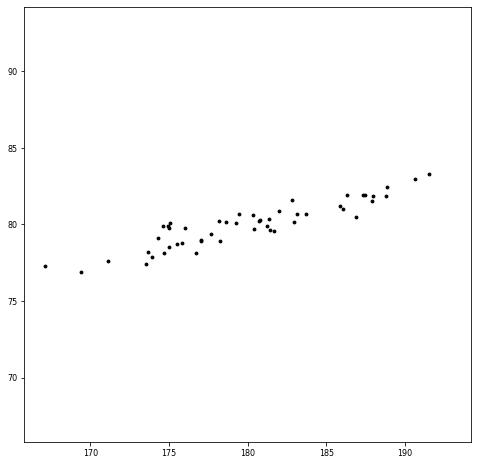

In [ ]:
param = param_widgets()
next_graph(0)

In [ ]:
"""






















































"""

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'